In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [17]:
# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Creating transform for our images
data_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [3]:
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

In [4]:
# Importing the dataset and creating dataloader.
train_dataset = datasets.FashionMNIST(root='./', train=True, transform=data_transform, download=True)
test_dataset = datasets.FashionMNIST(root='./', train=False, transform=data_transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 26421880/26421880 [00:02<00:00, 11149767.50it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 195757.49it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3703400.38it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1489738.99it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Visualizing a batch of random images from dataloader.

In [6]:
class_names = train_dataset.classes
num_classes = len(class_names)
class_names, num_classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

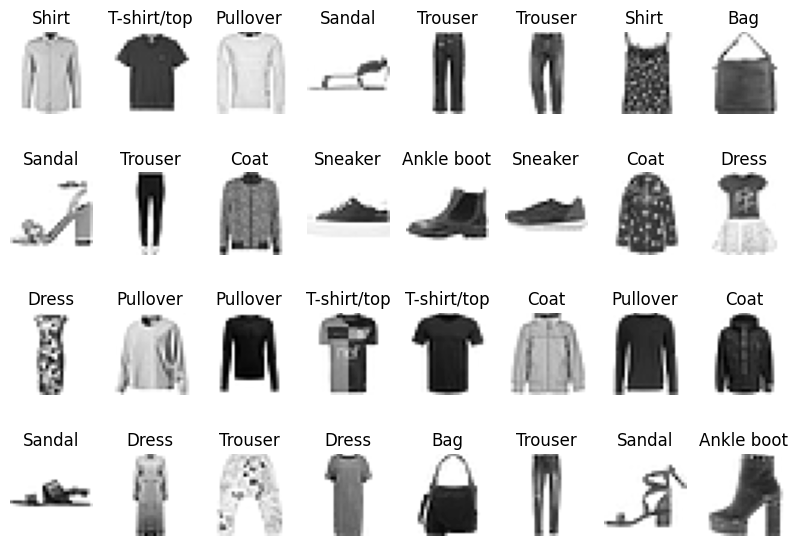

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
for i in range(BATCH_SIZE):
 plt.subplot(4, 8, 1 + i)
 image, label = next(iter(train_dataloader))
 image = image[i].permute(1, 2, 0)
 plt.title(f'{class_names[label[i].item()]}')
 plt.imshow(image, cmap='gray_r')
 plt.axis(False)
plt.show()

# How will we make the DCGAN conditional ?

### We first need to encode our labels.

There are 2 methods for encoding the label data -
- We can either use one hot encoding to encode the data. (`torch.nn.functional.one_hot()`). It's not the recommended way since we may have a lot of labels sometimes, for which we have to create huge one hot vectors that are sparse. This is not optimal for memory and computation.
- We can use the embedding layer from PyTorch (`nn.Embedding()`) and make it the same as our image size (28x28) and then use that layer as an additional dimension of the image.

The better method is using the embedding layer so we're going to use that in our model.

To make the GAN conditional all we need do for the generator is feed the class labels into the network. These are concatenated with the latent embedding before going through the transposed convolutional layers to generate an image.

For the critic, we can concatenate the class label with the flattened CNN features or we can add the label embedding to the image as an extra dimension so the fully connected layers can use that information to distinguish between the classes.

## Creating the Discriminator

In [8]:
# Creating the discriminator
class Discriminator(nn.Module):

  def __init__(self, in_channels):
    super().__init__()

    self.conv_layers = nn.Sequential(
        # Input --> BATCH_SIZE, 1, 28, 28
        nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 32, 14, 14

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 64, 7, 7

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 128, 3, 3

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        # nn.BatchNorm2d(256),  Didn't apply BatchNorm2d because it requres atleast (2, 2) tensor to apply normalization.
        nn.LeakyReLU(0.2, inplace=True)
        # Output Feature Maps --> BATCH_SIZE, 256, 1, 1
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*1*1, 10),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.classifier(self.conv_layers(x))

In [9]:
!pip -q install torchinfo

In [10]:
# Passing single image through to check if discriminator is functioning properly.
from torchinfo import summary
discriminator = Discriminator(in_channels = 1)
summary(model=discriminator, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 14, 14]           512
│    └─BatchNorm2d: 2-2                  [1, 32, 14, 14]           64
│    └─LeakyReLU: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 7, 7]             32,768
│    └─BatchNorm2d: 2-5                  [1, 64, 7, 7]             128
│    └─LeakyReLU: 2-6                    [1, 64, 7, 7]             --
│    └─Conv2d: 2-7                       [1, 128, 3, 3]            131,072
│    └─BatchNorm2d: 2-8                  [1, 128, 3, 3]            256
│    └─LeakyReLU: 2-9                    [1, 128, 3, 3]            --
│    └─Conv2d: 2-10                      [1, 256, 1, 1]            524,288
│    └─LeakyReLU: 2-11                   [1, 256, 1, 1]            -

In [11]:
image, label = next(iter(train_dataloader))
image = image[0].unsqueeze(dim=0)
discriminator(image)

tensor([[0.5170, 0.4338, 0.5107, 0.4911, 0.4866, 0.4579, 0.4200, 0.5209, 0.4945,
         0.4937]], grad_fn=<SigmoidBackward0>)

## Creating the Generator

For transpose convolutions on square tensors, the formula is -

H_out =(H_in - 1) * stride - 2 * padding + dilation * (kernel_size-1) + output_padding + 1

dilation is 1 by default, output padding is 0 by default

`H_out = (H_in-1) * stride + (kernel_size-1) - 2 * padding + 1`

In [12]:
latent_size = 128

In [13]:
class Generator(nn.Module):

  def __init__(self, z_dim):
    super().__init__()

    self.trans_conv_layers = nn.Sequential(
        # Input is latent dimension vector of size --> z_dim, 1, 1
        nn.ConvTranspose2d(z_dim, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # Output Size = 256, 2, 2

        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # Output Size = 128, 4, 4

        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # Output Size = 64, 8, 8

        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        # Output Size = 32, 16, 16

        nn.ConvTranspose2d(32, 1, 4, 2, 3),
        nn.Tanh()
        # Output Size = 1, 28, 28
    )

  def forward(self, noise):
    return self.trans_conv_layers(noise)

In [14]:
generator = Generator(128)
noise = torch.rand(size=[1, latent_size, 1, 1])
output = generator(noise)
output.shape

torch.Size([1, 1, 28, 28])

In [15]:
summary(model=generator, input_size=[1, 128, 1, 1])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-1              [1, 256, 2, 2]            524,544
│    └─BatchNorm2d: 2-2                  [1, 256, 2, 2]            512
│    └─ReLU: 2-3                         [1, 256, 2, 2]            --
│    └─ConvTranspose2d: 2-4              [1, 128, 4, 4]            524,416
│    └─BatchNorm2d: 2-5                  [1, 128, 4, 4]            256
│    └─ReLU: 2-6                         [1, 128, 4, 4]            --
│    └─ConvTranspose2d: 2-7              [1, 64, 8, 8]             131,136
│    └─BatchNorm2d: 2-8                  [1, 64, 8, 8]             128
│    └─ReLU: 2-9                         [1, 64, 8, 8]             --
│    └─ConvTranspose2d: 2-10             [1, 32, 16, 16]           32,800
│    └─BatchNorm2d: 2-11                 [1, 32, 16, 16]       

# Write training and testing loop

In [ ]:
def train_discriminator(discriminator: nn.Module, d_optim: torch.optim.Optimizer, real_images: torch.Tensor, loss_fn: nn.Module = nn.BCEWithLogitsLoss()):

  # Move images to correct device
  real_images = real_images.to(device)
  real_preds = discriminator(real_images)
  real_targets = torch.ones(size=[real_images.size[0], 1])
